In [25]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
TRAIN_FILE = './data/train_2.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TIME_STEP = 10;
INPUT_SIZE = 1;
HIDDEN_SIZE = 32;
DROPOUT_RATE = 0.0;

In [13]:
df = pd.read_csv(TRAIN_FILE)
print(df.head())

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09     ...      2017-09-01  2017-09-02  2017-

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [15]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


In [16]:
df.values.shape

(145063, 804)

In [17]:
raw_data = df.values[:, 1:] #remove category
raw_data.shape

(145063, 803)

In [36]:
raw_data.dtype

dtype('O')

In [37]:
# NaN to 0 and log1+1 transform
# raw_data[np.isnan(raw_data)] = 0
raw_data = np.log1p(np.nan_to_num(raw_data.astype('float')))

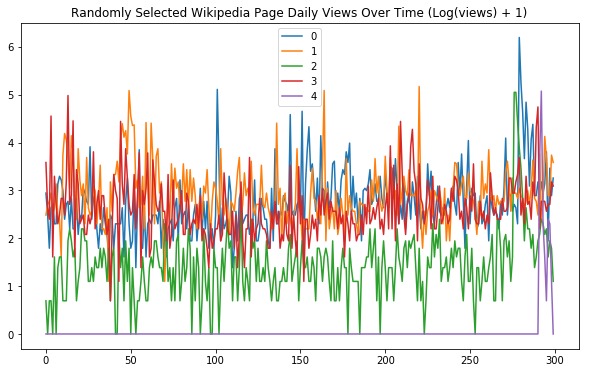

In [53]:
def plot_random_series(data, n_series, days):
    
    series_samples = data[:n_series, :days]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        plt.plot(series_samples[i, :])
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(list(range(n_series)))

plot_random_series(raw_data, 5, 300)

In [54]:
# raw_data shape (145063, 803)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# for the autoencoder

TIME_STEP = 10;
INPUT_SIZE = 1;
HIDDEN_SIZE = 32;
DROPOUT_RATE = 0.0;

In [57]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=DROPOUT_RATE,
        )

    def forward(self, input, h_state):
        output, h_n = self.gru(input, h_state)
        return output, h_n

In [158]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, time_step=TIME_STEP):
        super(DecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.time_step = time_step

        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=DROPOUT_RATE,
        )

        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, input, h_state):
        h_output, h_n = self.gru(input, h_state)
        print('h_output shape: ', h_output.shape, h_n.shape)
        h_output_reshaped = h_output.contiguous().view(-1, self.hidden_size)
        output = self.out(h_output_reshaped)
        print('output.shape: ', output.shape, self.time_step, self.hidden_size)
        #print('output: ', output)
        #output = output.view(-1,10,1)
        output = output.view(-1, self.time_step, self.input_size)

        return output, h_n

In [159]:
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, time_step=TIME_STEP):
        super(Seq2SeqModel, self).__init__()

        self.encoder = EncoderRNN(input_size, hidden_size);
        self.decoder = DecoderRNN(input_size, hidden_size, time_step);

    def forward(self, en_input, de_input, h_state):
        # assume input (batch, time_step, input_size)
        en_out, en_h_n = self.encoder(en_input, h_state)
        #print (en_out, en_out.shape, '---', en_h_n, en_h_n.shape)
        de_out, de_h_n = self.decoder(de_input, en_h_n)

        return de_out, de_h_n

In [160]:
seq2seq_modal = Seq2SeqModel()
optimizer = torch.optim.Adam(seq2seq_modal.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

In [161]:
def train(train_x, train_y, epoch):
    optimizer.zero_grad()

    for e in range(epoch):
        (x, y) = train_x, train_y
        # x (batch, en_time_step, input_size)
        # y (batch, de_time_step, output_size)
        #print (x.dtype, x[:, -1: ,:],'---', y[:, :-1, :])
        de_x = np.concatenate((x[:, -1: ,:],y[:, :-1, :]), axis=1)
        h_0 = torch.zeros(1, x.shape[0], HIDDEN_SIZE, device=device)

        x = torch.from_numpy(x)
        de_x = torch.from_numpy(de_x)
        y = torch.from_numpy(y)

        autoencoder = seq2seq_modal
        de_out, de_h_n = autoencoder(x, de_x, h_0)

        loss = loss_func(de_out, y)
        print('LOSS at epoch:', e, ' ', loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [162]:
sample_x = np.asarray(list(range(10)), dtype=np.float32)
sample_x = sample_x.reshape(1,10,1)
print (sample_x.shape)
train(sample_x, train_y=sample_x, epoch=2)

(1, 10, 1)
h_output shape:  torch.Size([1, 10, 32]) torch.Size([1, 1, 32])
output.shape:  torch.Size([10, 1]) 10 32
LOSS at epoch: 0   tensor(26.4325, grad_fn=<MseLossBackward>)
h_output shape:  torch.Size([1, 10, 32]) torch.Size([1, 1, 32])
output.shape:  torch.Size([10, 1]) 10 32
LOSS at epoch: 1   tensor(23.0861, grad_fn=<MseLossBackward>)


In [163]:
# use 10 days data to predit next 10 days data
data_10 = ((raw_data[:, :10])[:,:,np.newaxis]).astype(np.float32)
data_10_y = ((raw_data[:, 10:20])[:,:,np.newaxis]).astype(np.float32)
train(data_10, data_10_y, epoch=2)

h_output shape:  torch.Size([145063, 10, 32]) torch.Size([1, 145063, 32])
output.shape:  torch.Size([1450630, 1]) 10 32
LOSS at epoch: 0   tensor(14.3982, grad_fn=<MseLossBackward>)
h_output shape:  torch.Size([145063, 10, 32]) torch.Size([1, 145063, 32])
output.shape:  torch.Size([1450630, 1]) 10 32
LOSS at epoch: 1   tensor(11.5393, grad_fn=<MseLossBackward>)
